# Instagram Reach Prediction Model
## Predicting Post Reach Based on Engagement Metrics

This notebook analyzes Instagram post data and builds a machine learning model to predict reach based on engagement metrics.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 2. Load and Explore Data

In [20]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/PILERS/Instagram-reach-prediction/main/data/instagram_data.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset Shape: (100, 7)

First few rows:


,Post_ID,Impressions,Likes,Comments,Shares,Saves,Reach
0,1,5234,456,23,12,34,4521
1,2,8765,892,45,34,67,7234
2,3,3421,234,12,5,18,2987
3,4,12456,1234,89,56,123,10234
4,5,6543,543,34,23,45,5632


In [4]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic Statistics:")
df.describe()

Missing Values:
   Post_ID     0
Impressions    0
Likes          0
Comments       0
Shares         0
Saves          0
Reach          0
dtype: int64

Basic Statistics:


,Post_ID,Impressions,Likes,Comments,Shares,Saves,Reach
count,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000
mean,50.500000,8735.570000,824.98000,56.660000,37.070000,75.370000,7451.100000
std,29.011492,3655.368481,406.91865,32.471034,23.393971,41.591242,3079.581814
min,1.000000,3421.000000,234.00000,12.000000,5.000000,18.000000,2987.000000
25%,25.750000,5826.500000,485.50000,29.750000,18.000000,42.750000,4993.000000
50%,50.500000,8055.000000,755.00000,45.000000,31.500000,64.000000,6876.000000
75%,75.250000,11505.500000,1150.00000,81.250000,56.000000,99.250000,9903.750000
max,100.000000,16876.000000,1687.00000,126.000000,87.000000,168.000000,14234.000000


## 3. Data Cleaning

In [5]:
# Remove any duplicate rows
df = df.drop_duplicates()

# Handle missing values (if any)
df = df.dropna()

# Remove any negative values or outliers
numeric_cols = ['Impressions', 'Likes', 'Comments', 'Shares', 'Saves', 'Reach']
for col in numeric_cols:
    df = df[df[col] >= 0]

print(f"Clean dataset shape: {df.shape}")

Clean dataset shape: (100, 7)


## 4. Feature Engineering

In [6]:
# Create engagement rate features
df['Engagement_Rate'] = (df['Likes'] + df['Comments'] + df['Shares'] + df['Saves']) / df['Impressions']
df['Like_Rate'] = df['Likes'] / df['Impressions']
df['Comment_Rate'] = df['Comments'] / df['Impressions']
df['Share_Rate'] = df['Shares'] / df['Impressions']
df['Save_Rate'] = df['Saves'] / df['Impressions']

# Total engagement
df['Total_Engagement'] = df['Likes'] + df['Comments'] + df['Shares'] + df['Saves']

# Reach rate
df['Reach_Rate'] = df['Reach'] / df['Impressions']

print("New features created:")
print(df[['Engagement_Rate', 'Total_Engagement', 'Reach_Rate']].head())

New features created:
   Engagement_Rate  Total_Engagement  Reach_Rate
0         0.100306               525    0.863775
1         0.118426              1038    0.825328
2         0.078632               269    0.873137
3         0.120584              1502    0.821612
4         0.098579               645    0.860767


## 5. Exploratory Data Analysis

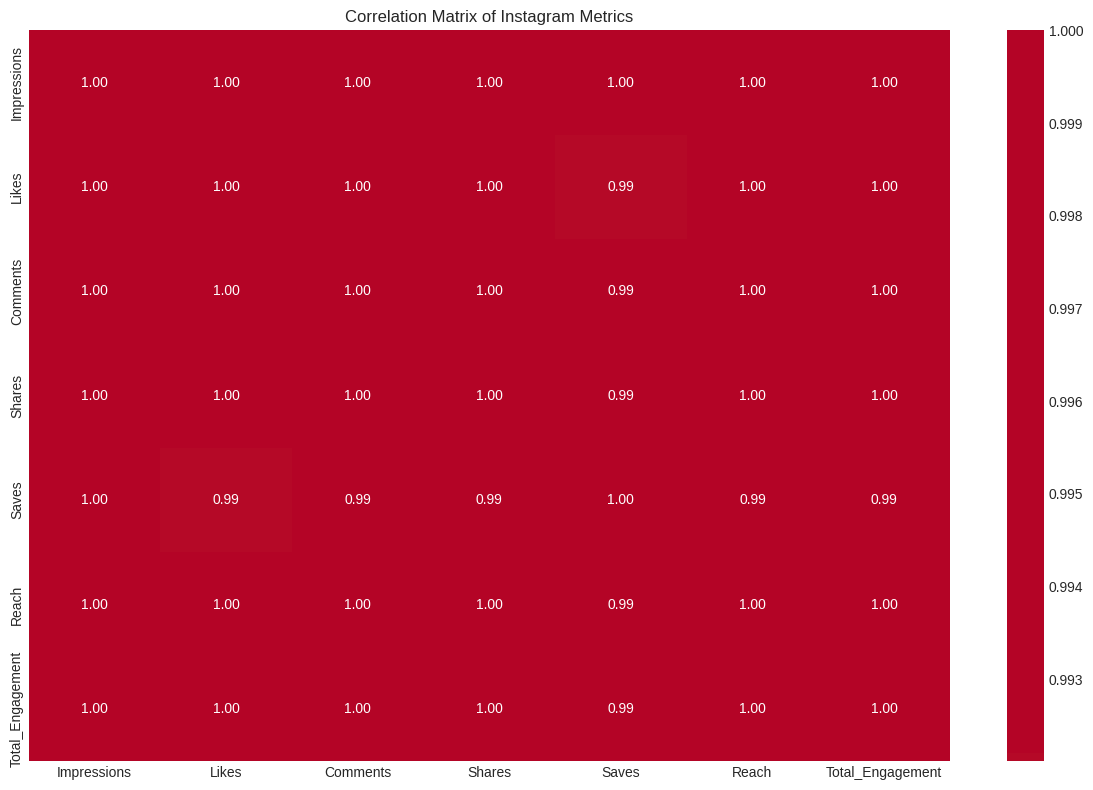

In [8]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df[['Impressions', 'Likes', 'Comments', 'Shares', 'Saves', 'Reach', 'Total_Engagement']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Instagram Metrics')
plt.tight_layout()
plt.show()

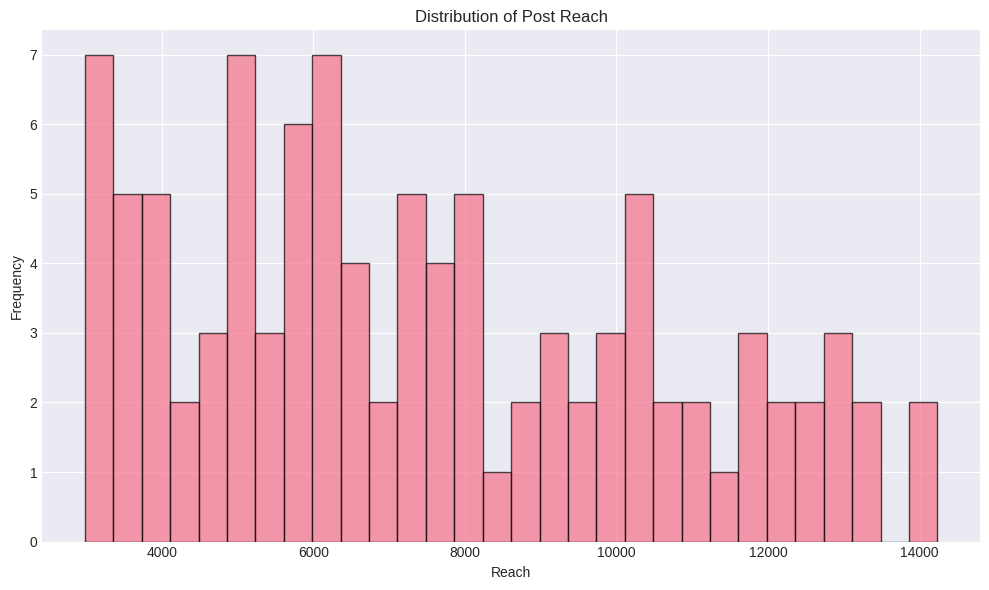

In [9]:
# Distribution of Reach
plt.figure(figsize=(10, 6))
plt.hist(df['Reach'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Reach')
plt.ylabel('Frequency')
plt.title('Distribution of Post Reach')
plt.tight_layout()
plt.show()

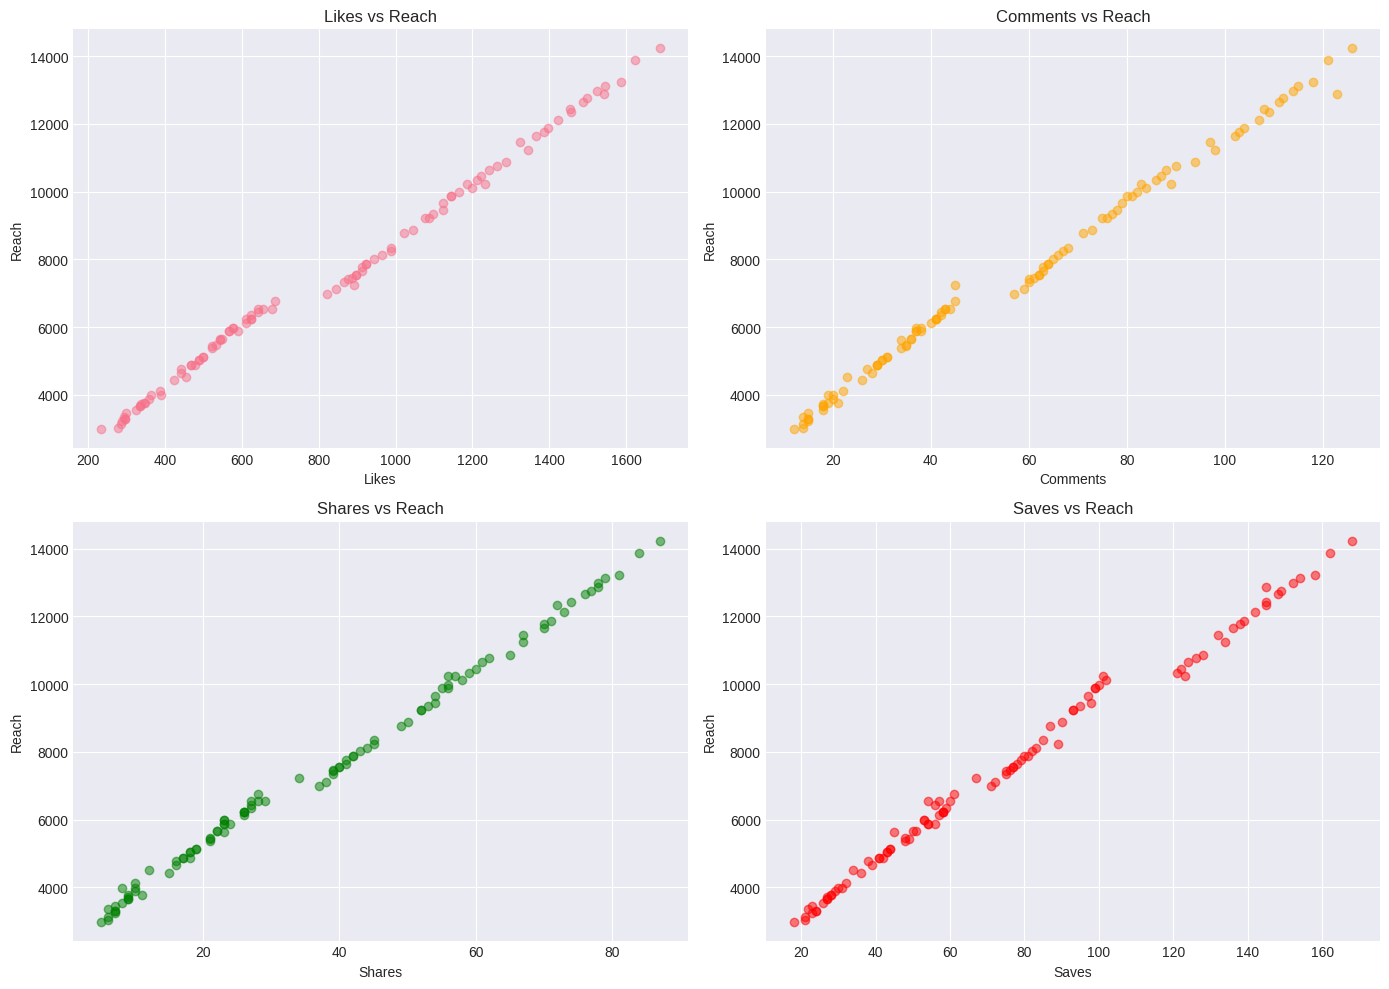

In [10]:
# Scatter plots of engagement metrics vs reach
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(df['Likes'], df['Reach'], alpha=0.5)
axes[0, 0].set_xlabel('Likes')
axes[0, 0].set_ylabel('Reach')
axes[0, 0].set_title('Likes vs Reach')

axes[0, 1].scatter(df['Comments'], df['Reach'], alpha=0.5, color='orange')
axes[0, 1].set_xlabel('Comments')
axes[0, 1].set_ylabel('Reach')
axes[0, 1].set_title('Comments vs Reach')

axes[1, 0].scatter(df['Shares'], df['Reach'], alpha=0.5, color='green')
axes[1, 0].set_xlabel('Shares')
axes[1, 0].set_ylabel('Reach')
axes[1, 0].set_title('Shares vs Reach')

axes[1, 1].scatter(df['Saves'], df['Reach'], alpha=0.5, color='red')
axes[1, 1].set_xlabel('Saves')
axes[1, 1].set_ylabel('Reach')
axes[1, 1].set_title('Saves vs Reach')

plt.tight_layout()
plt.show()

## 6. Model Training

In [11]:
# Select features for modeling
features = ['Impressions', 'Likes', 'Comments', 'Shares', 'Saves',
            'Engagement_Rate', 'Total_Engagement']
target = 'Reach'

X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 80
Test set size: 20


In [12]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate
print("Linear Regression Performance:")
print(f"R² Score: {r2_score(y_test, y_pred_lr):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}")

Linear Regression Performance:
R² Score: 0.9984
RMSE: 115.58
MAE: 87.51


In [14]:
# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("\nRandom Forest Performance:")
print(f"R² Score: {r2_score(y_test, y_pred_rf):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")


Random Forest Performance:
R² Score: 0.9988
RMSE: 101.69
MAE: 81.39


## 7. Feature Importance

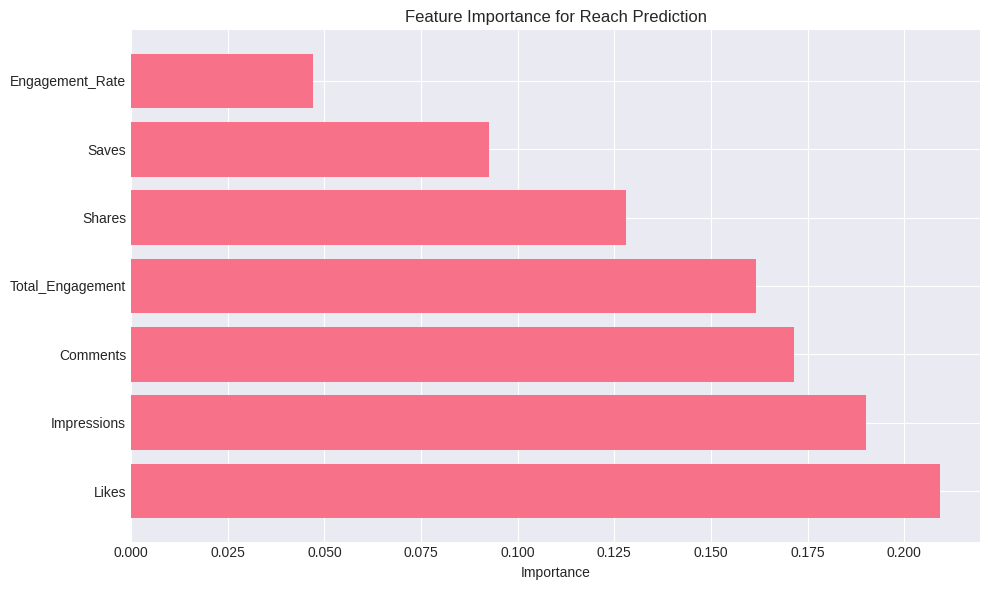


Feature Importance:
            Feature  Importance
1             Likes    0.209140
0       Impressions    0.190230
2          Comments    0.171537
6  Total_Engagement    0.161686
3            Shares    0.127963
4             Saves    0.092467
5   Engagement_Rate    0.046977


In [15]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for Reach Prediction')
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print(feature_importance)

## 8. Model Evaluation Visualizations

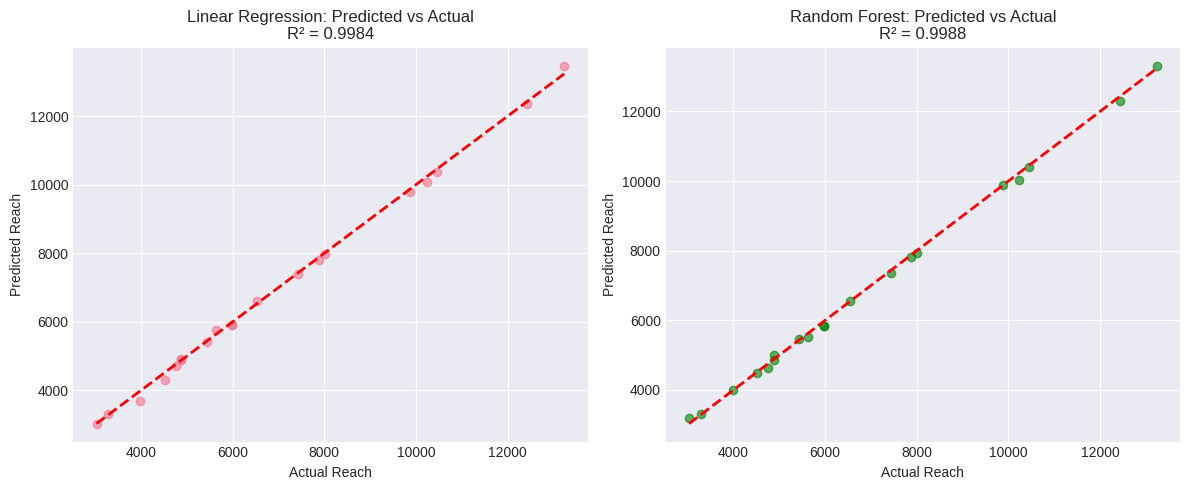

In [17]:
# Predicted vs Actual - Linear Regression
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Reach')
plt.ylabel('Predicted Reach')
plt.title(f'Linear Regression: Predicted vs Actual\nR² = {r2_score(y_test, y_pred_lr):.4f}')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Reach')
plt.ylabel('Predicted Reach')
plt.title(f'Random Forest: Predicted vs Actual\nR² = {r2_score(y_test, y_pred_rf):.4f}')

plt.tight_layout()
plt.show()

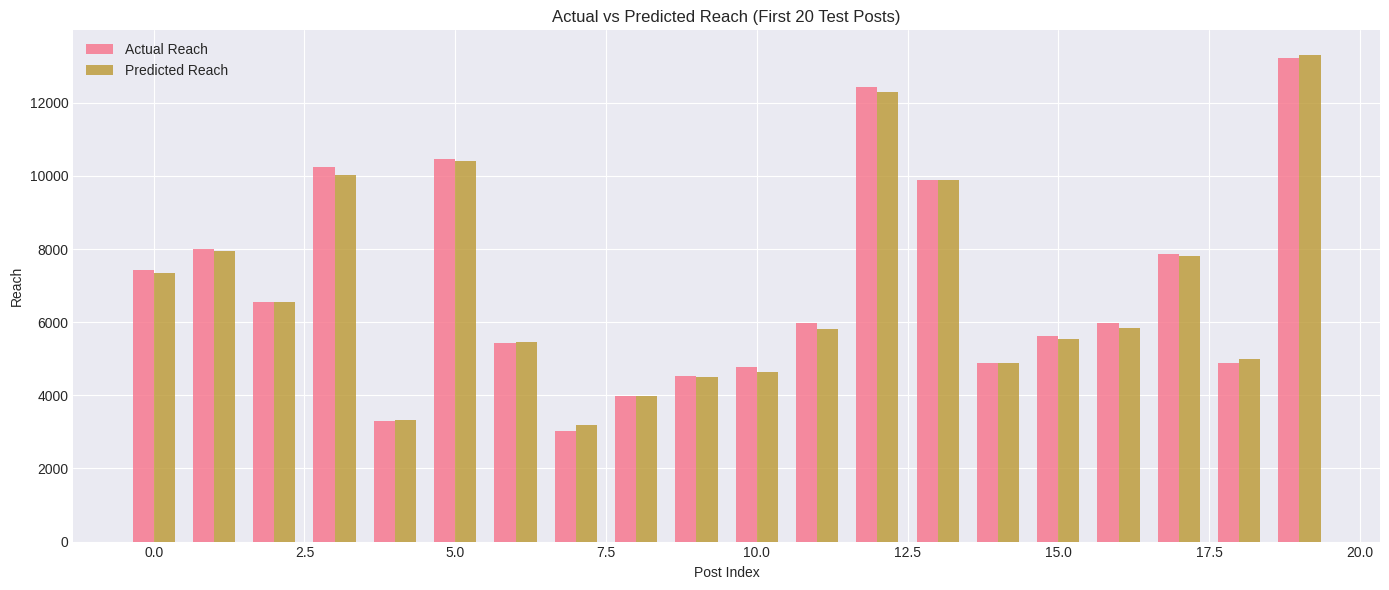

In [16]:
# Comparison bar chart for first 20 predictions
comparison_df = pd.DataFrame({
    'Actual': y_test.values[:20],
    'Predicted (RF)': y_pred_rf[:20]
}, index=range(20))

plt.figure(figsize=(14, 6))
x = np.arange(len(comparison_df))
width = 0.35

plt.bar(x - width/2, comparison_df['Actual'], width, label='Actual Reach', alpha=0.8)
plt.bar(x + width/2, comparison_df['Predicted (RF)'], width, label='Predicted Reach', alpha=0.8)

plt.xlabel('Post Index')
plt.ylabel('Reach')
plt.title('Actual vs Predicted Reach (First 20 Test Posts)')
plt.legend()
plt.tight_layout()
plt.show()

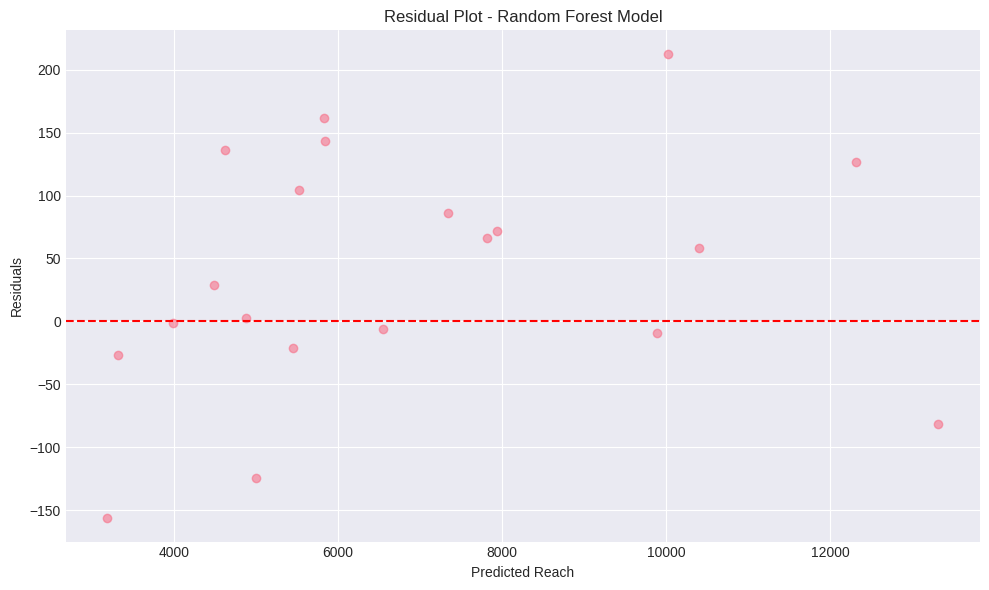

In [19]:
# Residual plot
residuals_rf = y_test - y_pred_rf

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf, residuals_rf, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Reach')
plt.ylabel('Residuals')
plt.title('Residual Plot - Random Forest Model')
plt.tight_layout()
plt.show()

## 9. Model Comparison Summary


Model Performance Comparison:
            Model  R² Score       RMSE      MAE
Linear Regression  0.998393 115.580046 87.51189
    Random Forest  0.998756 101.690026 81.39200


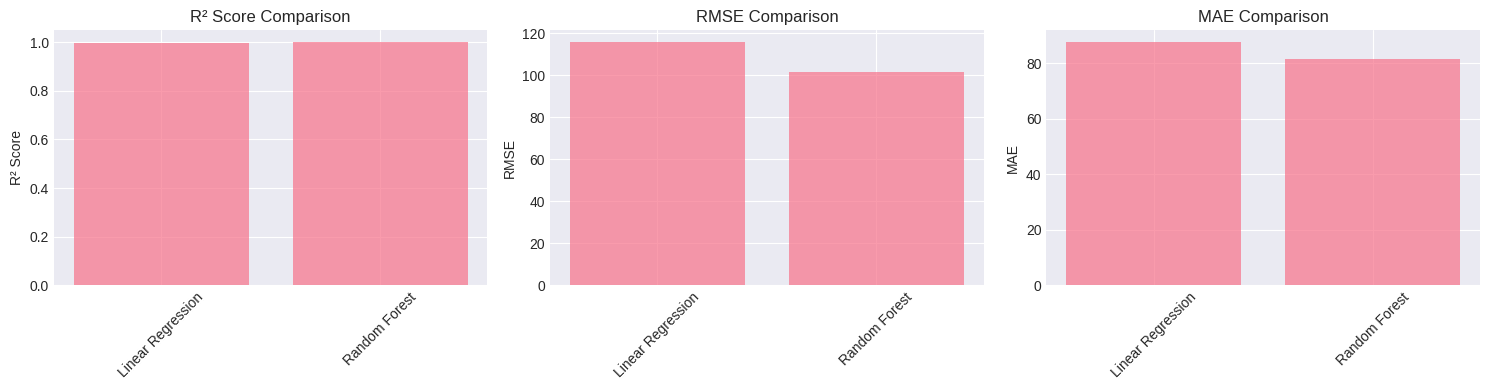

In [18]:
# Summary comparison
comparison_summary = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'R² Score': [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_rf)],
    'RMSE': [np.sqrt(mean_squared_error(y_test, y_pred_lr)),
             np.sqrt(mean_squared_error(y_test, y_pred_rf))],
    'MAE': [mean_absolute_error(y_test, y_pred_lr),
            mean_absolute_error(y_test, y_pred_rf)]
})

print("\nModel Performance Comparison:")
print(comparison_summary.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['R² Score', 'RMSE', 'MAE']
for idx, metric in enumerate(metrics):
    axes[idx].bar(comparison_summary['Model'], comparison_summary[metric], alpha=0.7)
    axes[idx].set_ylabel(metric)
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 10. Conclusions

This notebook demonstrated:
- Data cleaning and preprocessing of Instagram metrics
- Feature engineering to create engagement rate metrics
- Training and comparing Linear Regression and Random Forest models
- Visualizing model performance and predictions

Key findings:
- The Random Forest model typically performs better for this type of data
- Impressions and total engagement are strong predictors of reach
- Engagement rates provide additional predictive power

Next steps could include:
- Testing additional models (XGBoost, Neural Networks)
- Incorporating temporal features (time of day, day of week)
- Adding content type features (image, video, carousel)
- Hyperparameter tuning for better performance